In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import alpaca_trade_api as alpaca_trade_api
import numpy as np
import pandas as pd
from scipy.signal import find_peaks,find_peaks_cwt
#import mplfinance as mpf
import matplotlib.pyplot as plt
import datetime as datetime 
from BaseAlpha import BaseAlpha
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
%matplotlib inline


In [2]:
api = alpaca_trade_api.REST(key_id='PK714C2Y2AKEKG1GJHAQ',
                            secret_key='NwgIb/ZhtYWvEyulzuv6BfWnQJk0iqmxSnO/snKv',
                            base_url='https://paper-api.alpaca.markets',
                            api_version='v2')  
dt = datetime.datetime.today()
dt.strftime('%Y-%m-%dT%H:%M:%S.%f-04:00')


'2020-02-09T21:47:17.187611-04:00'

In [178]:
def getArrayFromBars(symbol,days):
        try:
            bars = api.get_barset(symbol, timeframe='day', limit=days)
        except alpaca_trade_api.rest.APIError as e:
            print("Error in get_avg_price while getting bars- ", e)
        ls_o = bars[symbol]
        list_close = [elem.c for elem in ls_o]
        list_open =  [elem.o for elem in ls_o]
        list_high =  [elem.h for elem in ls_o]
        list_low =   [elem.l for elem in ls_o]
        list_date =  [elem.t for elem in ls_o]
        list_vol =  [elem.v for elem in ls_o]
        np_symbol = np.array([list_close,list_open,list_high,list_low,list_vol])
        idx = pd.DatetimeIndex(list_date)
        np_symbol = np_symbol.transpose()
        df_symbol = pd.DataFrame(np_symbol,index=idx, columns = ['Close','Open','High','Low','Volume'])

        return df_symbol
    
df_symbol = getArrayFromBars('SPY',400)

trying out a weighed average strategy
 First calculate the difference between the Day's Close and Open -> C-O, CO indicates the magnitude of pull the Bulls Vs Bears 
 Now we need to figure out a way to see if the OC can give us a resonable indication of whether there is more Buying Pressure or selling Pressure
 We can calulate a weigted average of the CO over last n days, if n<L then there is enough sell pressure (Buy) if n>H there is enough buy pressure (sell)

In [179]:
dist = 14
peaks,pprops = find_peaks(df_symbol['Close'],distance=dist)
troughs,props = find_peaks(-1*df_symbol['Close'],distance=dist)

#df_stocks['volatility'] = df_symbol['Close MSFT'].rolling(window=dist).apply(np.std)

ar_peaks = peaks
ar_troughs = troughs

df_symbol['Peaks']=np.nan
df_symbol['Troughs']=np.nan

for x in ar_peaks:
    df_symbol['Peaks'][x]=df_symbol['Close'][x]

for x in ar_troughs:
    df_symbol['Troughs'][x]=df_symbol['Close'][x]


In [58]:
df_symbol.head()

,Close,Open,High,Low,Volume,Peaks,Troughs,Roll Peaks,Roll Troughs
2019-07-08 00:00:00-04:00,24.94,25.08,25.31,24.7200,2969201.0,NaN,NaN,NaN,NaN
2019-07-09 00:00:00-04:00,25.20,24.84,25.23,24.8400,2871517.0,NaN,NaN,NaN,NaN
2019-07-10 00:00:00-04:00,25.52,25.17,25.68,25.0663,5499183.0,NaN,NaN,NaN,NaN
2019-07-11 00:00:00-04:00,25.95,25.53,26.05,25.4250,4110406.0,NaN,NaN,NaN,NaN
2019-07-12 00:00:00-04:00,25.86,26.04,26.15,25.8300,2508993.0,NaN,NaN,NaN,NaN


4.0

/Users/harshupreti/Desktop/Trades/Alpaca/nightwatch/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:89: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/Users/harshupreti/Desktop/Trades/Alpaca/nightwatch/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:90: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


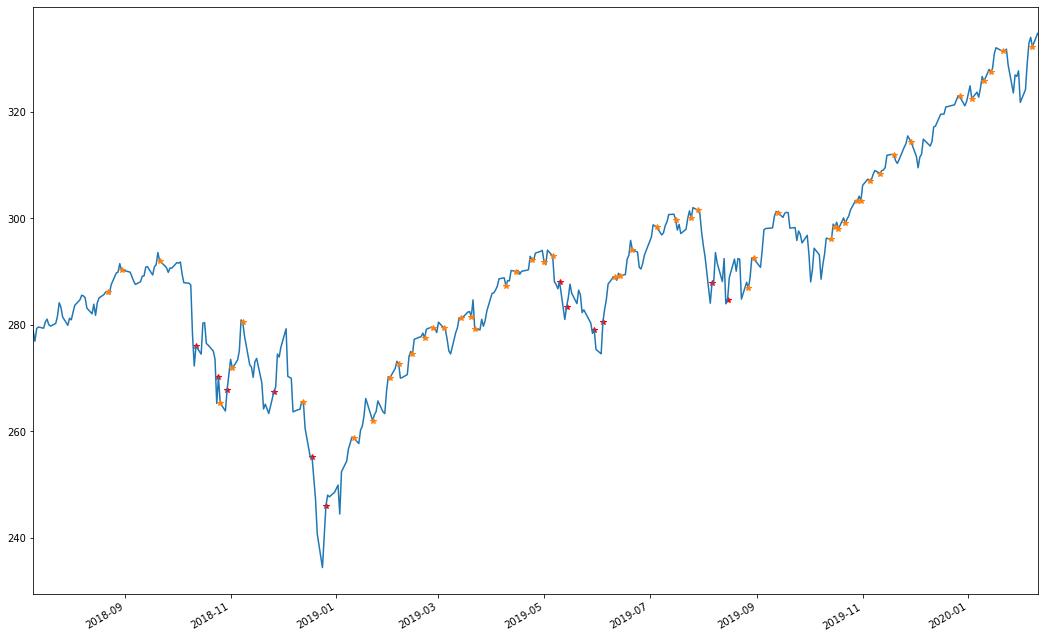

In [180]:
#ar_test=np.arange(1,10)
#ar_test = np.array([154,157,154,150,143,123,132,133,132])
dist=1

#Expects np array
def stockPeaks(prices):
    peaks=np.array([])
    ar_peaks = find_peaks(prices,distance=dist)
    for x in ar_peaks[0]:
        peaks=np.append(peaks,prices[x])
    if len(peaks) > 0:
        return peaks[-1]
    else:
        return np.nan

#Expects np array
def stockTroughs(prices):
    troughs=np.array([])
    ar_troughs = find_peaks(-1*prices,distance=dist)
    for x in ar_troughs[0]:
        troughs=np.append(troughs,prices[x])
    if len(troughs) >0:
        return troughs[-1]
    else:
        return np.nan

def isPeak(prices):
    ar_prices = np.array(prices)
    ar_peaks,props = find_peaks(ar_prices,distance=20)
    #ar_peaks = find_peaks_cwt(ar_prices,np.arange(3,7))
    #print(ar_peaks)
    if (ar_peaks.size>0) and (ar_peaks[-1] == ar_prices.size-2):
        return True
    else:
        return False

dist=60
def isTrough(prices):
    ar_prices = np.array(prices)
    ar_troughs,props = find_peaks(-1*ar_prices,distance=dist)
    #ar_troughs = find_peaks_cwt(-1*ar_prices,np.arange(3,7))
    if (ar_troughs.size>0) and (ar_troughs[-1] == ar_prices.size-2):
        return True
    else:
        return False
    
def isPeakTrend(prices):
    ar_prices = np.array(prices)
    ar_peaks = find_peaks(ar_prices,distance=dist)
    print(ar_peaks)
    if (ar_peaks[0].size>0) and (ar_peaks[0][-1] == ar_prices.size-2):
        return True
    else:
        return False

def isPeakTrend(prices):
    # Do not buy if last two troughs are decreasing
    dist = len(prices)/2
    ar_prices = np.array(prices)
    ar_peaks = find_peaks(ar_prices,distance=dist)[0]
    print(ar_peaks)
    if (ar_peaks.size>1) and (ar_peaks[-1] == ar_prices.size-2):
        return True
    # elif (ar_peaks.size==1) and (ar_peaks[-1] == ar_prices.size-2):
    #     return True
    else:
        return False

def isTroughTrend(prices):
    dist = len(prices)/2
    ar_prices = np.array(prices)
    ar_troughs = find_peaks(-1*ar_prices,distance=dist)[0]
    #print(prices)
    print(ar_troughs)
    if (ar_troughs.size>1) and (ar_troughs[-1] == ar_prices.size-2) and ar_prices[ar_troughs[-1]]>=ar_prices[ar_troughs[-2]] :
        return True
    # elif (ar_troughs.size==1) and (ar_troughs[-1] == ar_prices.size-2):
    #     return True
    else:
        return False

ar_test = np.array([1,3,2,3,4,2,4,4,1.5,4,1,3,1,2,3,4,1,4,4,1,4,2])
ar_test1 = np.array([12,13,12,11,12])

#findpeaks(ar_test)
#isPeak(ar_test)
#isTroughTrend(ar_test1)
stockPeaks(ar_test)
df_symbol['Roll Peaks']=df_symbol['Close'].rolling(window=28).apply(isPeak)
df_symbol['Roll Troughs']=df_symbol['Close'].rolling(window=28).apply(isTrough)

idxp = df_symbol[df_symbol['Roll Peaks']==1.0].index
df_symbol['Roll Peaks'][idxp]=df_symbol['Close'][idxp]
zp = df_symbol[df_symbol['Roll Peaks']==0].index
df_symbol['Roll Peaks'][zp]=np.nan

idxt = df_symbol[df_symbol['Roll Troughs']==1.0].index
df_symbol['Roll Troughs'][idxt]=df_symbol['Close'][idxt]
zt = df_symbol[df_symbol['Roll Troughs']==0].index
df_symbol['Roll Troughs'][zt]=np.nan

#df_stocks['Peaks'].plot(style=".",color="green")
df_symbol['Roll Troughs'].plot(style="*",color="red")
df_symbol['Close'].plot(style="-")
df_symbol['Roll Peaks'].plot(style="*", figsize=[18,12])
#xlim=[pd.Timestamp('2018-05-05'),pd.Timestamp('2018-09-05')]
#df_stocks['volatility'].plot()

In [181]:
def strikeRate(r):
    return len(r[r>0])/len(r)
    

ret3 = -1*df_symbol['Close'].pct_change(periods=-3)[idxt]
ret5 = -1*df_symbol['Close'].pct_change(periods=-5)[idxt]
ret10 = -1*df_symbol['Close'].pct_change(periods=-10)[idxt]
ret15 = -1*df_symbol['Close'].pct_change(periods=-15)[idxt]
ret20 = -1*df_symbol['Close'].pct_change(periods=-20)[idxt]
ret25 = -1*df_symbol['Close'].pct_change(periods=-25)[idxt]
ret30 = -1*df_symbol['Close'].pct_change(periods=-30)[idxt]
ret35 = -1*df_symbol['Close'].pct_change(periods=-35)[idxt]
m
print("3")
print(ret3.describe())
print(strikeRate(ret3))
print("5")
print(ret5.describe())
print(strikeRate(ret5))
print("10")
print(ret10.describe())
print(strikeRate(ret10))
print("15")
print(ret15.describe())
print(strikeRate(ret15))
print("20")
print(ret20.describe())
print(strikeRate(ret20))
print("25")
print(ret25.describe())
print(strikeRate(ret25))
print("30")
print(ret30.describe())
print(strikeRate(ret30))
print("35")
print(ret35.describe())
print(strikeRate(ret35))

3
count    12.000000
mean      0.004667
std       0.023072
min      -0.059777
25%       0.001755
50%       0.011761
75%       0.016362
max       0.024719
Name: Close, dtype: float64
0.75
5
count    12.000000
mean      0.011077
std       0.021197
min      -0.037242
25%      -0.001045
50%       0.014128
75%       0.026194
max       0.042220
Name: Close, dtype: float64
0.75
10
count    12.000000
mean      0.006757
std       0.032555
min      -0.043606
25%      -0.017959
50%       0.011741
75%       0.036629
max       0.050127
Name: Close, dtype: float64
0.5833333333333334
15
count    12.000000
mean      0.007942
std       0.037413
min      -0.049137
25%      -0.014178
50%       0.004605
75%       0.037710
max       0.064364
Name: Close, dtype: float64
0.5
20
count    12.000000
mean      0.017842
std       0.042591
min      -0.087413
25%       0.005692
50%       0.022731
75%       0.045573
max       0.074294
Name: Close, dtype: float64
0.8333333333333334
25
count    12.000000
mean      0.0

In [131]:
ret3

2019-01-30 00:00:00-05:00    0.015886
2019-02-04 00:00:00-05:00   -0.006704
2019-02-08 00:00:00-05:00    0.017819
2019-02-15 00:00:00-05:00    0.000685
2019-02-22 00:00:00-05:00    0.000287
2019-03-01 00:00:00-05:00   -0.011540
2019-03-11 00:00:00-04:00    0.009566
2019-04-10 00:00:00-04:00    0.005862
2019-04-26 00:00:00-04:00   -0.005482
2019-05-03 00:00:00-04:00   -0.022465
2019-05-10 00:00:00-04:00   -0.010419
2019-05-14 00:00:00-04:00    0.008989
2019-05-30 00:00:00-04:00    0.005240
2019-06-04 00:00:00-04:00    0.024719
2019-07-09 00:00:00-04:00    0.011374
2019-07-18 00:00:00-04:00    0.003767
2019-07-22 00:00:00-04:00    0.006799
2019-07-26 00:00:00-04:00   -0.015434
2019-08-06 00:00:00-04:00    0.013101
2019-08-15 00:00:00-04:00    0.018480
2019-09-17 00:00:00-04:00   -0.009425
2019-09-25 00:00:00-04:00   -0.002728
2019-09-30 00:00:00-04:00   -0.022111
2019-10-03 00:00:00-04:00   -0.006307
2019-11-01 00:00:00-04:00    0.003223
2019-11-22 00:00:00-05:00    0.014138
2019-12-04 0

In [151]:

df = pd.DataFrame({
    'GOOG':[5, 10, 15, 20,15 ]})
pct = df.pct_change(periods=-1)
ret3[ret3<0]


2019-05-21 00:00:00-04:00   -0.028442
2019-05-31 00:00:00-04:00   -0.013714
2019-06-04 00:00:00-04:00   -0.039754
2019-06-27 00:00:00-04:00   -0.011100
2019-08-22 00:00:00-04:00   -0.040665
2019-09-27 00:00:00-04:00   -0.095526
2019-10-04 00:00:00-04:00   -0.031455
2019-11-11 00:00:00-05:00   -0.006564
2019-11-13 00:00:00-05:00   -0.003450
2019-12-06 00:00:00-05:00   -0.021592
2020-01-21 00:00:00-05:00   -0.044444
2020-01-23 00:00:00-05:00   -0.108734
Name: Close, dtype: float64